## Import Libraries

In [3]:
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.axes_style('whitegrid');
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import scipy.io as sio
from spectral import *
from scipy.io import loadmat

## Read the Data

In [4]:
def read_HSI():
    X = loadmat('PaviaU.mat')['paviaU']
    y = loadmat('PaviaU_gt.mat')['paviaU_gt']
    print(f"X shape:{X.shape}\ny shape: {y.shape}")
    return X,y
X, y = read_HSI()

X shape:(610, 340, 103)
y shape: (610, 340)


### Visualize Bands

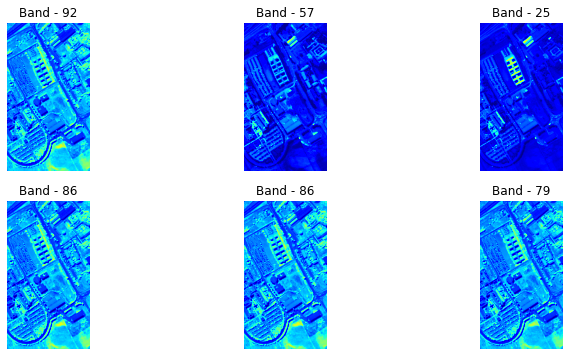

In [5]:
fig = plt.figure(figsize = (12, 6))

for i in range(1, 1+6):
    fig.add_subplot(2,3, i)
    q = np.random.randint(X.shape[2])
    plt.imshow(X[:,:,q], cmap='jet')
    plt.axis('off')
    plt.title(f'Band - {q}')
plt.savefig('IP_Bands.png')

### Visualize the Ground Truth

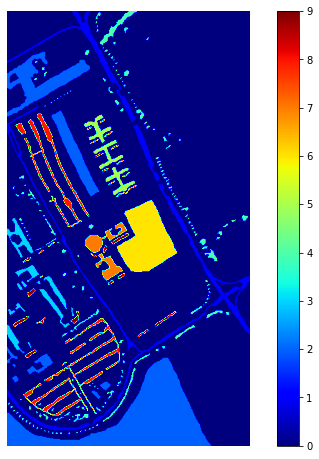

In [6]:
plt.figure(figsize=(10, 8))
plt.imshow(y, cmap='jet')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_GT.png')
plt.show()

## Convert the dataset into csv 

In [7]:
import pandas as pd
import numpy as np

def extract_pixels(X, y):
  q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
  df.to_csv('Dataset.csv')
  return df
  
df = extract_pixels(X, y)


In [36]:
df.shape

(207400, 104)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207400 entries, 0 to 207399
Columns: 104 entries, band1 to class
dtypes: uint16(103), uint8(1)
memory usage: 40.9 MB


In [10]:
df.iloc[:, :-1].describe()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band94,band95,band96,band97,band98,band99,band100,band101,band102,band103
count,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,...,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000
mean,925.324995,850.237584,800.363558,809.889783,830.085950,834.162700,833.530641,825.932729,823.827637,830.388689,...,2262.503269,2266.693293,2257.763443,2249.329595,2246.216779,2238.254364,2231.822647,2224.744884,2236.901707,2253.451692
std,444.427499,468.464292,493.590158,527.235307,555.419089,574.543548,592.474167,605.782075,619.492506,636.532214,...,863.285910,863.351557,857.286520,845.571285,833.001117,826.922155,827.403828,827.257369,834.092348,844.165146
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,145.000000,146.000000,150.000000,140.000000,0.000000,134.000000,0.000000
25%,649.000000,555.000000,483.000000,473.000000,480.000000,474.000000,461.000000,444.000000,433.000000,430.000000,...,1696.000000,1699.000000,1693.000000,1690.000000,1696.000000,1692.000000,1685.000000,1675.000000,1682.000000,1692.000000
50%,857.000000,762.000000,694.000000,690.000000,693.000000,681.000000,671.000000,661.000000,657.000000,658.000000,...,2246.000000,2252.000000,2244.000000,2236.000000,2238.000000,2235.000000,2231.000000,2226.000000,2244.000000,2261.000000
75%,1111.000000,1046.000000,1015.000000,1036.000000,1058.000000,1066.000000,1068.000000,1064.000000,1066.000000,1080.000000,...,2724.000000,2730.000000,2721.000000,2711.000000,2701.000000,2688.000000,2683.000000,2677.000000,2692.000000,2715.000000
max,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000


## Principal Component Analysis(PCA)


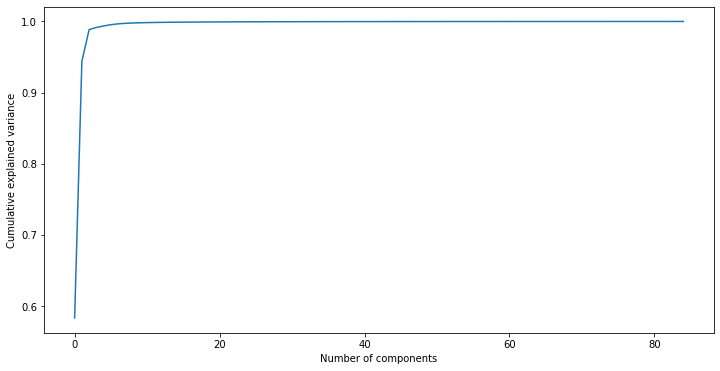

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 85)

principalComponents = pca.fit_transform(df.iloc[:, :-1].values)

ev=pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


plt.show()


Select 40 as the no.of components for PCA

In [12]:
pca = PCA(n_components = 40)
dt = pca.fit_transform(df.iloc[:, :-1].values)
q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = y.ravel())], axis = 1)
q.columns = [f'PC-{i}' for i in range(1,41)]+['class']

In [13]:
q['class'].unique()

array([0, 1, 4, 2, 8, 5, 9, 6, 3, 7], dtype=uint8)

In [14]:
# saving to .csv
q.to_csv('IP_40_PCA.csv', index=False)

## Support Vector Machine(SVM)


In [15]:
x = q[q['class']!= 0]

X = x.iloc[:, :-1].values

y = x.loc[:, 'class'].values 

names = ['Asphalt','Meadows','Gravel','Trees','Painted metal sheets','Bare Soil','Bitumen','Self-Blocking Bricks','Shadows']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11, stratify=y)

svm =  SVC(C = 100, kernel = 'rbf', cache_size = 10*1024)

svm.fit(X_train, y_train)

ypred = svm.predict(X_test)

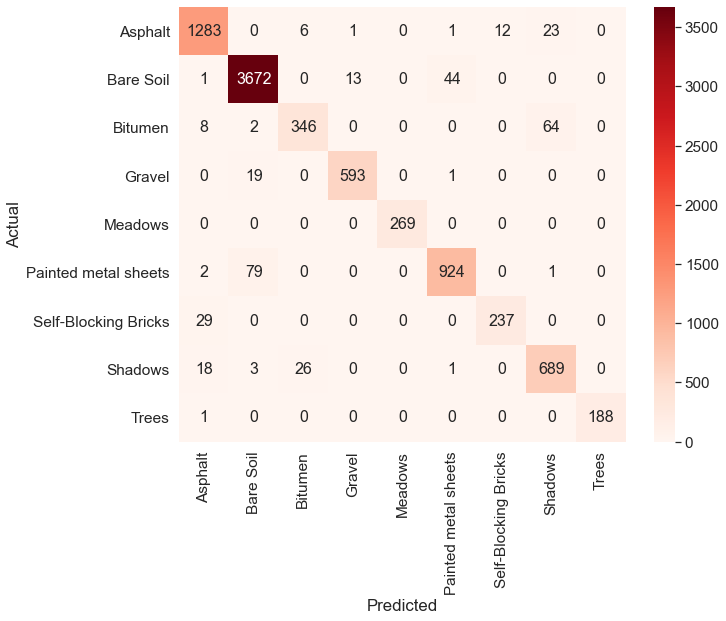

In [16]:
data = confusion_matrix(y_test, ypred)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)

In [17]:
print(classification_report(y_test, ypred, target_names = names))

                      precision    recall  f1-score   support

             Asphalt       0.96      0.97      0.96      1326
             Meadows       0.97      0.98      0.98      3730
              Gravel       0.92      0.82      0.87       420
               Trees       0.98      0.97      0.97       613
Painted metal sheets       1.00      1.00      1.00       269
           Bare Soil       0.95      0.92      0.93      1006
             Bitumen       0.95      0.89      0.92       266
Self-Blocking Bricks       0.89      0.93      0.91       737
             Shadows       1.00      0.99      1.00       189

            accuracy                           0.96      8556
           macro avg       0.96      0.94      0.95      8556
        weighted avg       0.96      0.96      0.96      8556





---



---

